# Evoluční algoritmy - Genetické programování

Dneska se podíváme na jednoduché genetické programování. Vyzkoušíme si ho na problému symbolické regrese, kdy bude naším cílem nalézt vzoreček, který bude nejlépe odpovídat zadaným datům, a klasifikace, kdy budeme hledat rozhodovací strom pomocí genetického programování.

K tomuto budeme používat knihovnu deap, kterou jsme si ukázali minule.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pydot
from IPython.display import Image

import operator
from deap import gp
from deap import creator, base, tools, algorithms

import pydot
from IPython.display import Image

Nejprve si vygenerujeme data v nějakém rozumném rozsahu a k nim odpovídající labely, například pomocí funkce sinus. Pro ně pak budeme chtít najít vzoreček regrese, který jim bude nejlépe odpovídat.

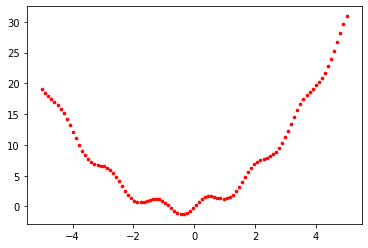

In [2]:
x_train = np.linspace(-5, 5, 100)
y_train = x_train*x_train + x_train + np.sin(4*x_train)

plt.scatter(x_train, y_train,s=7,c='r')
plt.show()

Pro práci s genetickým algoritmem budeme potřebovat vyvořit množinu terminálů a neterminálů, se kterými bude evoluce pracovat. K tomu v knihovně deap existuje třída `gp.PrimitiveSet`, případně `gp.PrimitiveSetTyped` pro typované GP. V našem příkladu použijeme tu typovanou verzi, protože je obecnější. Jelikož ale budeme používat jen jeden typ jedinců, šla by použít i netypovaná verze. Jako terminály si definujeme konstanty 0,1,2, zbytek se dovytvoří z nich během evoluce. Jako neterminály budeme potřebovat operace sčítání, násobení a sinus, a protože zbylé operace se ve vzorečku nevyskytují, nebudeme si jimi zbytečně komplikovat život.

In [3]:
# mnozina se jmenuje MAIN, vstup je jeden float, vystup je taky jeden float
pset = gp.PrimitiveSetTyped('MAIN', [float], float) 

# terminaly
pset.addTerminal(1.0, float)
pset.addTerminal(2.0, float)
pset.addTerminal(0.0, float)


# neterminaly
pset.addPrimitive(np.sin, [float], float)
pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)
#pset.addPrimitive(operator.sub, [float, float], float)
#pset.addPrimitive(np.cos, [float], float)
#pset.addPrimitive(operator.truediv, [float, float], float)

Když máme vytvořené terminály a neterminály, můžeme si definovat jedince, fitness funkci a genetické operátory. Jedince vygenerujeme jako náhodné stromy z množiny primitiv a nastavíme jim počáteční minimální a maximální hloubku. Fitness funkce bude MSE (Mean Squared Error), která počítá střední hodnoty druhých mocnin rozdílů mezi predikovanou výstupní hodnotou a skutečnou výstupní hodnotou, tedy čtvercovou vzdálenost jak daleko je predikovaný výstup od skutečného. Nastavíme jí váhu -1, protože chceme chybu minimalizovat. Zároveň nastavíme i váhu -0.01, která penalizuje počet uzlů ve stromu, abychom evoluci nutili k vytváření spíše menších jedinců. Selekci použijeme turnajovou, křížení jednobodové, kdy se klasicky náhodně zvolí bod a v něm se prohodí části podstromů, a uniformní mutaci, která náhodně vybere místo v jedinci a nahradí podstrom za kořen výrazu vygenerovanou pomocí metody ```expr()``` na základě definovaných operací a konstant. Zároveň přidáme limity na hloubku stromu pri křížení a mutaci, aby nám stromy zbytečně nebobtnaly.

In [4]:
# definujeme fitness 
def fitness(ind, x, y):
    func = toolbox.compile(expr=ind) # vytvorime funkci podle jedince
    vals = list(map(func, x)) # zavolame funkci na data
    return np.sqrt(np.dot(vals-y, vals-y)), len(ind) #spocitame chybu pomoci MSE

# vytvorime tridy pro jedince
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -0.01))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# nastavime algoritmus
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, type_=float, min_=3, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", fitness, x=x_train, y=y_train)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset) 

# limity na hloubku stromu
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

Nyní jsme si napsali všechny potřebné operátory a definovali jsme si populaci, tak si ještě dodefinujeme nějaké statistické metody, abychom mohli sledovat vývoj evoluce a pak můžeme náš algoritmus genetického programování pustit.

In [5]:
pop = toolbox.population(n=1000)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 100, stats=mstats, halloffame=hof, verbose=True)

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max   	min    	nevals	std    	avg   	gen	max	min	nevals	std    
0  	1000  	3298.82	0  	995428	28.0234	1000  	46977.8	70.787	0  	808	4  	1000  	117.987
1  	557   	116.391	1  	3762.49	28.0234	557   	126.473	49.629	1  	777	2  	557   	93.0472
2  	538   	106.139	2  	1348.47	21.8382	538   	55.8724	44.214	2  	778	2  	538   	94.4042
3  	564   	95.4493	3  	1626.23	19.9098	564   	68.9521	53.386	3  	779	2  	564   	117.068
4  	560   	85.1707	4  	1805.72	11.763 	560   	89.9279	93.177	4  	785	3  	560   	165.039
5  	531   	83.1135	5  	13673.7	11.763 	531   	450.672	161.361	5  	785	2  	531   	202.901
6  	563   	63.6016	6  	8970.41	7.46224	563   	329.752	268.028	6  	779	5  	563   	196.437
7  	525   	34.4643	7  	879.975	7.03293	525   	41.4062	343.279	7  	601	3  	525   	1

Vidíme, že výstup výše je sice krásný a určitě bohatě vypovídající, ale asi bychom víc ocenili nějakou vizualici. Proto si napíšeme pomocnou funkci na zobrazení vytvořeného stromu. To uděláme pomocí knihovny *pydot*, která slouží právě ke zobrazování grafů.

In [6]:
# zobrazeni jedince jako stromu
def plot_tree(tree):
    nodes, edges, labels = gp.graph(tree)
    nodesDot = list(map(lambda x: pydot.Node(x, label=str(labels.get(x))),nodes))

    g = pydot.Dot(graph_type='graph')
    for node in nodesDot:
        g.add_node(node)
    for f,t in edges:
        edge = pydot.Edge(nodesDot[f], nodesDot[t])
        g.add_edge(edge)

    return g.create_png()

In [7]:
Image(plot_tree(hof[0]))

FileNotFoundError: [Errno 2] "dot" not found in path.

Ještě si napíšeme jednoduchou funkci, která nám vykreslí graf, abychom se mohli podívat, jak vypadá naše naučená funkce vzhledem k datům. Když máme štěstí na dobrý běh tak vidíme, že se nám podařilo nalézt funkci téměř ideálně pasující na naše data.

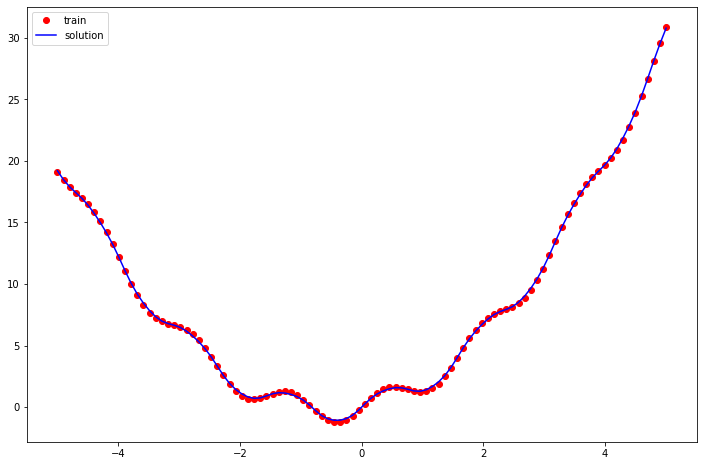

In [ ]:
sol = gp.compile(hof[0], pset)

y = list(map(sol, x_train))
plt.figure(figsize=(12, 8))
plt.plot(x_train, y_train, 'ro', label='train')
plt.plot(x_train, y, 'b',label='solution')
plt.legend()
plt.show()

## Úkol na cvičení

Zkuste pomocí genetického programování řešit problém klasifikace pro dataset Iris, se kterým jsme pracovali na prvním cvičení. Promyslete si, jak definovat množinu primitiv a fitness. Následně je naimplementujte je a pusťte genetické programování.